In [2]:
import pandas as pd
df = pd.read_excel("Presidentielle_2017_Resultats_Communes_Tour_1_c.xls",skiprows=3)


df_list = []
code_commune = df["Code du département"].astype(str).str.pad(2,"left","0") + df["Code de la commune"].astype(str).str.pad(3,"left","0")
candidat =  df[[f"N°Panneau",f"Sexe",f"Nom",f"Prénom",f"Voix",f"% Voix/Ins",f"% Voix/Exp"]]
cand_1 = pd.concat([code_commune,candidat],axis=1)
cand_1.columns = ["code_commune",f"N°Panneau",f"Sexe",f"Nom",f"Prénom",f"Voix",f"% Voix/Ins",f"% Voix/Exp"]
df_list.append(cand_1)
for n in range(1,11):
    candidat =  df[[f"N°Panneau.{n}",f"Sexe.{n}",f"Nom.{n}",f"Prénom.{n}",f"Voix.{n}",f"% Voix/Ins.{n}",f"% Voix/Exp.{n}"]]
    cand_1 = pd.concat([code_commune,candidat],axis=1)
    cand_1.columns = ["code_commune",f"N°Panneau",f"Sexe",f"Nom",f"Prénom",f"Voix",f"% Voix/Ins",f"% Voix/Exp"]
    df_list.append(cand_1)
df_final = pd.concat(df_list)
voix = df_final[["code_commune","Nom","Voix"]]

epci = pd.read_excel("Intercommunalite_Metropole_au_01-01-2021/Intercommunalite-Metropole_au_01-01-2021.xlsx",sheet_name="Composition_communale",skiprows=5, dtype={"CODGEO" :str, "EPCI" : str})
dic_epci = epci[["LIBEPCI","CODGEO","EPCI"]]

voix_epci  = dic_epci.merge(voix,left_on="CODGEO",right_on="code_commune").groupby(["LIBEPCI","EPCI","Nom"],as_index=False)["Voix"].sum()
votants = pd.concat([code_commune, df["Votants"]],axis=1)
votants_epci = dic_epci.merge(votants, left_on="CODGEO",right_on=0).groupby('EPCI',as_index=False)['Votants'].sum()
df_voix = voix_epci.merge(votants_epci,on="EPCI")
df_voix["share"] = (df_voix["Voix"]/df_voix['Votants']*100).round(2)
df_voix

df_pop = pd.read_csv("ensemble/Communes.csv",sep=";", dtype={"CODCOM" : str})
df_pop["CODGEO"] = df_pop["CODDEP"] + df_pop["CODCOM"].str.pad(3,"left","0")
pop = df_pop[["CODGEO","PTOT"]]
pop_epci = dic_epci.merge(pop,on="CODGEO").groupby("EPCI")["PTOT"].sum()



<ipython-input-6-538f125c8155>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["taux_cumu_1_inj"] = data["taux_cumu_1_inj"]*100


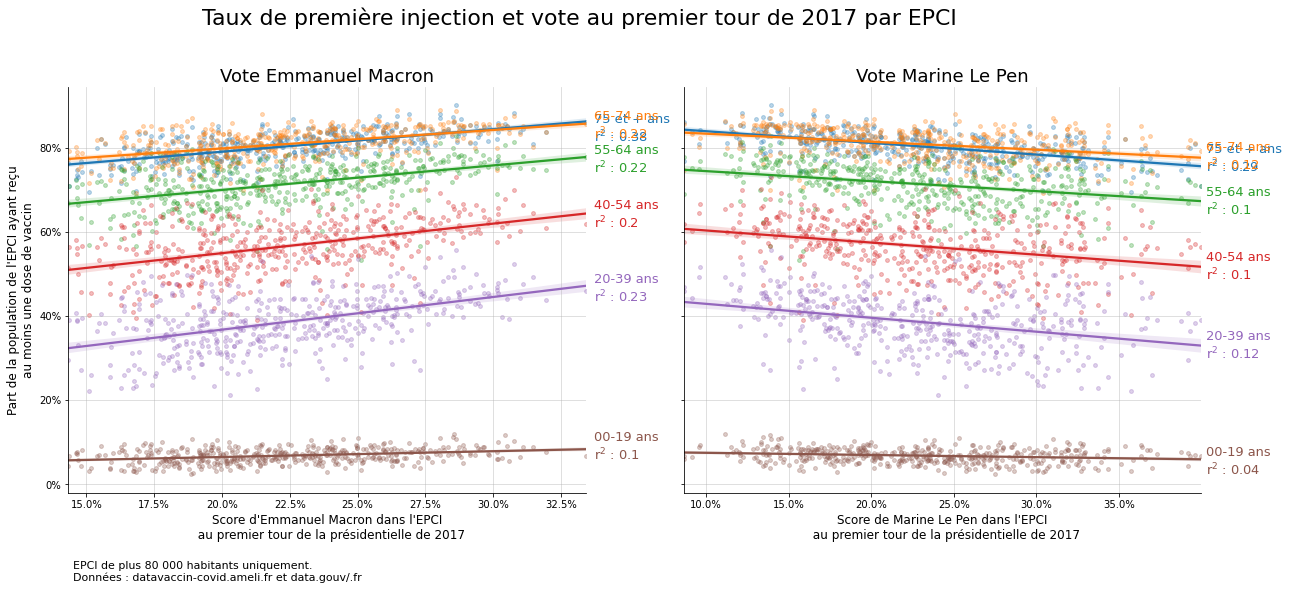

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams



df = pd.read_csv("donnees-de-vaccination-par-epci.csv",sep=";",parse_dates=["date"], dtype={"epci" : str})
df = df.merge(pop_epci,left_on="epci",right_on="EPCI")
min_pop = 30000
max_pop = 700000000
df= df[(df["PTOT"] > min_pop) & (df["PTOT"] < max_pop)]


mask = (df["date"] == df["date"].sort_values().iloc[-1]) & (df["classe_age"] != "TOUT_AGE") 
data = df[mask]
data["taux_cumu_1_inj"] = data["taux_cumu_1_inj"]*100

fig,(ax1,ax2) = plt.subplots(figsize=(18,8),ncols=2,sharey=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12

data = df_voix.merge(data,left_on="EPCI",right_on="epci")
for age in data["classe_age"].sort_values(ascending=False).unique():

    d = data[(data['classe_age'] == age) & (data["Nom"] == "MACRON")]
    sns.regplot(data=d, x="share",y="taux_cumu_1_inj",scatter_kws={'alpha':0.3, "s" : 15},ax=ax1,label=age)
    
    color = [ i.get_color() for i in ax1.get_lines()][-1]
    
    r2 = (d.corr()["taux_cumu_1_inj"]["share"]**2).round(2)

    ax1.text(d["share"].max()+0.3, d["taux_cumu_1_inj"].quantile(0.9), f"{age} ans\nr$^2$ : {r2}", color=color,va="center",fontsize=13)
    
    d = data[(data['classe_age'] == age) & (data["Nom"] == "LE PEN")]
    sns.regplot(data=d, x="share",y="taux_cumu_1_inj",scatter_kws={'alpha':0.3, "s" : 15},ax=ax2,label=age)
    
    r2 = (d.corr()["taux_cumu_1_inj"]["share"]**2).round(2)

    ax2.text(d["share"].max()+0.3, d["taux_cumu_1_inj"].quantile(0.2), f"{age} ans\nr$^2$ : {r2}", color=color,va="center",fontsize=13)


fig.suptitle('Taux de première injection et vote au premier tour de 2017 par EPCI',fontsize=22,x=0.45,y=1.03)

ax1.set_title("Vote Emmanuel Macron",fontsize=18)
ax1.set_ylabel("Part de la population de l'EPCI ayant reçu\nau moins une dose de vaccin")
ax1.set_xlabel("Score d'Emmanuel Macron dans l'EPCI\n  au premier tour de la présidentielle de 2017")
ax1.yaxis.set_major_formatter(lambda x, pos : f"{int(x)}%")
ax1.xaxis.set_major_formatter(lambda x, pos : f"{x}%")
ax1.grid(alpha=0.5)

ax2.set_title("Vote Marine Le Pen",fontsize=18)
ax2.set_ylabel("")
ax2.set_xlabel("Score de Marine Le Pen dans l'EPCI\n  au premier tour de la présidentielle de 2017")
ax2.xaxis.set_major_formatter(lambda x, pos : f"{x}%")
ax2.grid(alpha=0.5)

ax1.text(14.5,-23,"EPCI de plus 80 000 habitants uniquement.\nDonnées : datavaccin-covid.ameli.fr et data.gouv/.fr",fontsize=11)
sns.despine()
plt.tight_layout()
fig.savefig('rr.svg',facecolor="w",bbox_inches='tight')

In [276]:
pd.qcut(pop_epci,10).value_counts()

,LIBEPCI,EPCI,Nom,Voix,Votants,share,date_reference,semaine_injection,epci,libelle_epci,...,effectif_termine,effectif_cumu_1_inj,effectif_cumu_termine,taux_1_inj,taux_termine,taux_cumu_1_inj,taux_cumu_termine,date,reg_code,PTOT
0,CA Annonay Rhône Agglo,200072015,ARTHAUD,205,28156,0.73,2021-06-27,2021-25,200072015,CA ANNONAY RHONE AGGLO,...,60.0,610.0,150.0,0.011,0.005,5.7,0.014,2021-06-27,84,50010
1,CA Annonay Rhône Agglo,200072015,ARTHAUD,205,28156,0.73,2021-06-27,2021-25,200072015,CA ANNONAY RHONE AGGLO,...,450.0,3430.0,1540.0,0.020,0.042,32.3,0.145,2021-06-27,84,50010
2,CA Annonay Rhône Agglo,200072015,ARTHAUD,205,28156,0.73,2021-06-27,2021-25,200072015,CA ANNONAY RHONE AGGLO,...,770.0,4990.0,2940.0,0.014,0.079,51.2,0.302,2021-06-27,84,50010
3,CA Annonay Rhône Agglo,200072015,ARTHAUD,205,28156,0.73,2021-06-27,2021-25,200072015,CA ANNONAY RHONE AGGLO,...,410.0,4370.0,3350.0,0.010,0.064,67.4,0.516,2021-06-27,84,50010
4,CA Annonay Rhône Agglo,200072015,ARTHAUD,205,28156,0.73,2021-06-27,2021-25,200072015,CA ANNONAY RHONE AGGLO,...,270.0,4920.0,4350.0,0.006,0.043,79.7,0.705,2021-06-27,84,50010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18475,CU d'Alençon,246100663,POUTOU,388,30857,1.26,2021-06-27,2021-25,246100663,CU D ALENÇON,...,500.0,5590.0,3440.0,0.014,0.066,74.5,0.458,2021-06-27,"28,52",57774
18476,CU d'Alençon,246100663,POUTOU,388,30857,1.26,2021-06-27,2021-25,246100663,CU D ALENÇON,...,50.0,870.0,100.0,0.025,0.005,7.4,0.008,2021-06-27,"28,52",57774
18477,CU d'Alençon,246100663,POUTOU,388,30857,1.26,2021-06-27,2021-25,246100663,CU D ALENÇON,...,370.0,4850.0,1580.0,0.032,0.032,42.2,0.137,2021-06-27,"28,52",57774
18478,CU d'Alençon,246100663,POUTOU,388,30857,1.26,2021-06-27,2021-25,246100663,CU D ALENÇON,...,410.0,6520.0,5220.0,0.009,0.051,82.9,0.663,2021-06-27,"28,52",57774


In [230]:
df_pop = pd.read_csv("ensemble/Communes.csv",sep=";", dtype={"CODCOM" : str})
df_pop["CODGEO"] = df_pop["CODDEP"] + df_pop["CODCOM"].str.pad(3,"left","0")
pop = df_pop[["CODGEO","PTOT"]]
pop_epci = dic_epci.merge(pop,on="CODGEO").groupby("EPCI")["PTOT"].sum()



29.382000000000005